In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [3]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [4]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [5]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_rebased=top/top.sum()
            top_dict=top_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_dict: 
                    weight_dict[key]=top_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [6]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(0,len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).T.iloc[4:].cumsum(axis=0)
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [8]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
#url='https://en.wikipedia.org/wiki/CAC_40'
table = pd.read_html(url)
df = table[0]

In [9]:
columns=pd.read_excel('Rebalancing.xlsx',index_col=0).columns

In [10]:
tickers=df['Symbol'].tolist()

In [11]:
# marketcap_dico={}
# for ticker in tickers:
#     try:

#         ticker_data = yf.Ticker(ticker)
#         current_market_cap = ticker_data.info['marketCap']
#         marketcap_dico[ticker]=current_market_cap
#     except:
#         print('Error with: ', ticker)

In [12]:
# market_cap=pd.read_excel('Market Cap.xlsx',index_col=0)

# tickers=list(market_cap.sort_values(by='Market Cap',ascending=False).iloc[:530].index)


In [13]:
# tickers.remove('PLTR')
# tickers.remove('SMCI')
# tickers.remove('UBER')
# tickers.remove('CRWD')

In [14]:
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime(2020,3,15)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

$BRK.B: possibly delisted; no timezone found
$BF.B: possibly delisted; no price data found  (1d 2020-03-15 -> 2025-02-26)


In [15]:
with_no_na=dataframe.columns[np.where((dataframe.isna().sum()<10))]

In [16]:
dataframe=dataframe[with_no_na].copy()

In [17]:
sp500=get_close(['SPY'],start=start_date,end=end_date)
sp500_leverage=get_close(['XS2D.L'],start=start_date,end=end_date)

# Analysis

In [19]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

In [20]:
mrat_weights = mrat_weights[~mrat_weights.index.duplicated(keep='first')]

In [21]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=15,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17956\3430555856.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


2020-03-16 00:00:00 100 1.0
2020-12-31 00:00:00 170.903681545408 1.70903681545408
2021-01-29 00:00:00 179.75405348018697 1.7975405348018696
2021-02-26 00:00:00 194.1588791530195 1.941588791530195
2021-03-31 00:00:00 189.8130572036496 1.898130572036496
2021-04-30 00:00:00 195.25373095276498 1.95253730952765
2021-06-01 00:00:00 203.40319115688885 2.0340319115688885
2021-06-30 00:00:00 203.0893316787756 2.030893316787756
2021-07-30 00:00:00 204.93306517780917 2.049330651778092
2021-08-31 00:00:00 221.4839272163767 2.214839272163767
2021-09-30 00:00:00 202.40556540436364 2.0240556540436363
2021-10-29 00:00:00 222.70609920115186 2.2270609920115185
2021-11-30 00:00:00 222.15643827745112 2.221564382774511
2021-12-31 00:00:00 212.97485981250185 2.1297485981250186
2022-01-31 00:00:00 191.40893007875005 1.9140893007875004
2022-02-28 00:00:00 202.3962163759043 2.023962163759043
2022-03-31 00:00:00 235.04200824686123 2.350420082468612
2022-04-29 00:00:00 226.45364402382137 2.2645364402382135
2022-

In [22]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
TPR,0.075742
UAL,0.073707
AXON,0.070226
VST,0.069327
FFIV,0.066240
TSLA,0.065876
TPL,0.065345
RCL,0.065071
FTNT,0.065005


In [23]:
dates_end[-3]

Timestamp('2025-01-31 00:00:00')

In [24]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [25]:
equal_weight=shares*dataframe

In [26]:
pnl=get_pnl(portfolio)

In [27]:
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))

In [28]:
pnl_contrib[pnl_contrib.columns[0]]

Total    1.000000
SMCI     0.153277
NVDA     0.148213
VST      0.099059
TPL      0.063398
           ...   
UHS     -0.019355
ENPH    -0.026816
AMD     -0.028709
TSLA    -0.030535
CCL     -0.041201
Name: 2025-01-31 00:00:00, Length: 493, dtype: float64

In [29]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_17956\89254820.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  performance_pct=performance_pct.pct_change()


<Axes: >

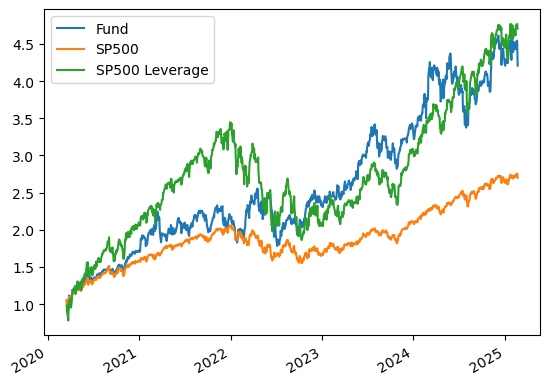

In [30]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['SP500']=sp500
#performance['Equal Weight']=equal_weight.sum(axis=1)
performance['SP500 Leverage']=sp500_leverage

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [31]:
years=sorted(list(set(performance.index.year)))

In [32]:
month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

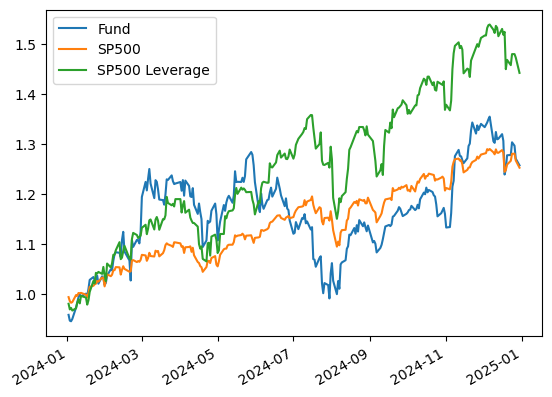

In [33]:
(1+performance_pct.loc[str(2024)].iloc[:-1]).cumprod().plot()

In [34]:
year_returns={}
year_returns[years[0]]=performance.loc[str(years[0])].iloc[-1]/performance.loc[str(years[0])].iloc[0]-1
for i in range(len(years)-1):

    perf_year=performance.loc[str(years[i+1])].iloc[-1]/performance.loc[str(years[i])].iloc[-1]-1
    year_returns[years[i+1]]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-2])].iloc[-1]-1

In [35]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,0.724636,0.246169,0.090208,0.451747,0.247953,-0.061908
SP500,0.587918,0.287288,-0.181754,0.261758,0.248865,0.018991
SP500 Leverage,1.088802,0.630291,-0.390880,0.488736,0.456542,0.021306


In [36]:
month_returns={}
month_returns[month_year[0]]=performance.loc[str(month_year[0])].iloc[-1]/performance.loc[str(month_year[0])].iloc[0]-1
for i in range(len(month_year)-1):

    perf_year=performance.loc[str(month_year[i+1])].iloc[-1]/performance.loc[str(month_year[i])].iloc[-1]-1
    month_returns[month_year[i+1]]=perf_year

month_returns[month_year[-1]]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-2])].iloc[-1]-1

In [37]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe.T.sort_values(by='Fund')

,Fund,SP500,SP500 Leverage
2022-06,-0.201557,-0.082460,-0.161198
2025-02,-0.117833,-0.007660,-0.032873
2022-01,-0.101260,-0.052741,-0.130247
2024-07,-0.092497,0.012109,0.004436
2021-09,-0.086139,-0.046606,-0.071808
2024-12,-0.069448,-0.024060,-0.037400
2024-06,-0.062652,0.035280,0.111924
2023-09,-0.060271,-0.047435,-0.093772
2023-10,-0.057019,-0.021709,-0.070553
2023-08,-0.055928,-0.016252,-0.030374


In [38]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500'].iloc[-2]/performance['SP500'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [39]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.499813
Fund Vol,0.541122
Bench Vol,0.186688
Fund Return,3.982154
Bench Return,2.685649
Sharpe Ratio,2.415134


In [40]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['SP500 Leverage']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['SP500 Leverage'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['SP500 Leverage'].iloc[-2]/performance['SP500 Leverage'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(dataframe.index.year)))/metrics['Fund Vol']

In [41]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.558348
Fund Vol,0.541122
Bench Vol,0.356416
Fund Return,3.982154
Bench Return,4.593694
Sharpe Ratio,2.415134


In [42]:
# shares=pd.DataFrame()
# for date in dates_end[:-1]:
#     shares[date]=tracking[date][1]
# shares=shares.T

In [43]:
# positions=pd.DataFrame()
# positions.index=dataframe.index
# positions=pd.concat([positions,shares],axis=1)
# positions=positions.ffill()

In [44]:
#dataframe.iloc[:-1].to_excel('SP500 Prices.xlsx')
#positions[:-1].to_excel('Rebalancing.xlsx')